<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Lecture_3_codes_Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
! pip install mlxtend #stepwise
! pip install joblib
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 9.1 MB/s 


In [2]:
# Import the required libraries to solve our case
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as skSFS
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import shap
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings("ignore")
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the data
df = pd.read_excel("/content/drive/MyDrive/MGTF 405/PredictorData2021.xlsx",0)
date = pd.to_datetime(df['yyyymm'], format='%Y%m', errors='coerce')
df['excess_returns'] = df['CRSP_SPvw'] -df['Rfree'] 
df.drop(['Index','CRSP_SPvw','Rfree','csp','CRSP_SPvwx','yyyymm'], axis=1, inplace=True)


In [5]:
# separate the dependent and independent variable
X = df.loc[515:df.shape[0]-2].reset_index(drop=True)
Y = df.loc[516:,'excess_returns'].reset_index(drop=True)
X.drop(['excess_returns'],axis=1,inplace=True)
X=sm.add_constant(X)
date=date[516:]

In [6]:
# Divide the data into train, validation and test
train_X = X[:379]
train_Y = Y[:379]
train_date=date[:379]
val_X = X[379:439]
val_Y = Y[379:439]
val_date=date[379:440]
test_X = X[440:]
test_Y = Y[440:]
test_date=date[440:]
train_val_X=X[:439]
train_val_Y=Y[:439]

In [ ]:
# Define a function to calculate Mean Squared Error
def MSE(actual, pred):
    sse = [(a-p)**2 for a,p in zip(actual,pred)]
    return(np.mean(sse))

## Step wise linear regression

In [ ]:
# stepwise linear regression function.
# Inputs = independent train set, dependent train set, type of selection, number of features to sleect, independent test set
# Output = predicted values on train set and predicted value on test set

def forward_stepwise_selection(input_data,to_predict,k,cc,return_features=True):
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    param_list=[]
    predict_is=[]
    predict_oos=[]
    rmse_train=[]
    rmse_test=[]
    r_squared=[]
    const_list=['const']
    lr = LinearRegression()  #Linear regression function
    for i in range(start,len(X)):
      x_new = X.loc[:start-1,]
      y_new = Y[:start]
      sfs = SFS(lr, k_features=k, #stepwise selection 
                    forward=True, 
                    scoring='neg_mean_squared_error',
                    cv=0)
      sfs = sfs.fit(x_new, y_new) # fit the stepwise model
      x_train=sm.add_constant(x_new[np.array(sfs.subsets_[k]['feature_names']).tolist()])
      reg=sm.OLS(y_new,x_train).fit()
      prediction_train=reg.predict(sm.add_constant(x_new[np.array(sfs.subsets_[k]['feature_names']).tolist()]))
      predict_is.append(prediction_train)
      x_test=pd.DataFrame(X.loc[i]).T
      prediction_test=reg.predict(sm.add_constant(x_test[const_list+np.array(sfs.subsets_[k]['feature_names']).tolist()]))
      predict_oos.append(prediction_test)
      param_list.append(np.array(np.array(sfs.subsets_[k]['feature_names']).tolist()))
      rmse_train.append(mean_squared_error(y_new, prediction_train))
      r_squared.append(r2_score(y_new, prediction_train))
      rmse_train.append(mean_squared_error(y_new, prediction_train))
      start = i
      x_new = x_new.append(pd.DataFrame(X.loc[start]).T)
      y_new = y_new.append(pd.Series(Y[start]))
    rmse_test.append(mean_squared_error(to_predict[cc:], predict_oos))    
    
    if return_features:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos, param_list
    else:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos

def backward_stepwise_selection(input_data,to_predict,k,cc,return_features=True):
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    param_list=[]
    predict_is=[]
    predict_oos=[]
    rmse_train=[]
    rmse_test=[]
    r_squared=[]
    const_list=['0']
    lr = LinearRegression()  #Linear regression function
    for i in range(start,len(X)):
        sfs = SFS(lr, k_features=k, #stepwise selection 
              forward=False, 
              scoring='neg_mean_squared_error',
              cv=0)
        sfs = sfs.fit(x_new.values, y_new.values)
        names_list=const_list+np.array(sfs.subsets_[k]['feature_names']).tolist()
        names=list(map(int, names_list))
        x_train = x_new.iloc[:,names]
        reg=sm.OLS(y_new,x_train).fit()
        prediction_train=reg.predict(x_train)
        predict_is.append(prediction_train)
        x_test=pd.DataFrame(input_data.loc[i]).T
        prediction_test=reg.predict(x_test.iloc[:,names])
        predict_oos.append(prediction_test)
        param_list.append(names)
        r_squared.append(r2_score(y_new, prediction_train))
        rmse_train.append(mean_squared_error(y_new, prediction_train))
        start = i
        x_new = x_new.append(pd.DataFrame(X.loc[start]).T)
        y_new = y_new.append(pd.Series(Y[start]))
        y_new=y_new.reset_index(drop=True)

    rmse_test.append(mean_squared_error(to_predict[cc:], predict_oos))    
    
    if return_features:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos, param_list
    else:
      return rmse_train, rmse_test, r_squared,predict_is,predict_oos


In [ ]:
f_rmse_train,f_rmse_test, f_r_squared, f_predict_is, f_predict_oos, f_param_list=forward_stepwise_selection(X,Y,3,440)
b_rmse_train,b_rmse_test, b_r_squared, b_predict_is, b_predict_oos, b_param_list=backward_stepwise_selection(X,Y,3,440)


In [ ]:
pd.DataFrame(f_param_list[59]).T

,0,1,2
0,AAA,ltr,corpr


In [ ]:
X.columns[b_param_list[59]]

Index(['const', 'b/m', 'BAA', 'corpr'], dtype='object')

In [ ]:
oos_forecast_fss=pd.concat([test_Y,pd.DataFrame(f_predict_oos).sum(axis=0)],axis=1)
oos_forecast_fss.columns=['actual','forecast']
oos_forecast_fss.index=test_date

is_fit=pd.concat([Y,pd.DataFrame(f_predict_is).T],axis=1)
is_fit.index=date

Text(0.5, 1.0, 'Forward Stepwise- In Sample Fit')

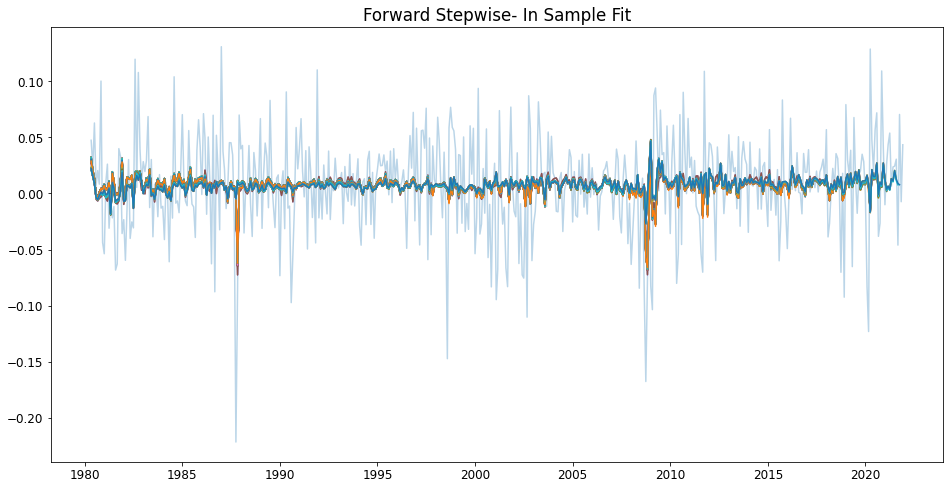

In [ ]:
plt.plot(is_fit['excess_returns'],alpha=0.3)
plt.plot(is_fit.iloc[:,1:])
plt.title('Forward Stepwise- In Sample Fit')

Text(0.5, 1.0, 'Forward Stepwise Test data')

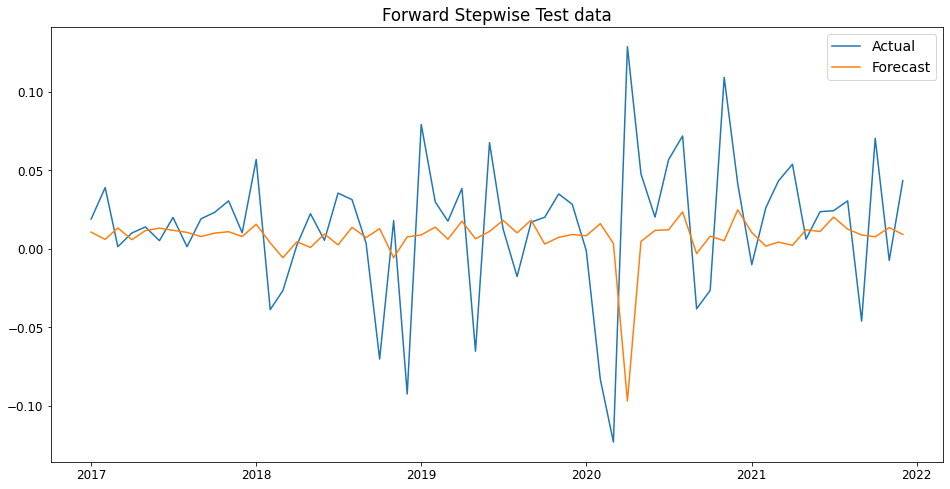

In [ ]:
plt.plot(oos_forecast_fss['actual'])
plt.plot(oos_forecast_fss['forecast'])

# #plt.xlabel('date')
# plt.plot(test_date,res.predict(test_X))
plt.legend(('Actual','Forecast'))
plt.title('Forward Stepwise Test data')
# plt.savefig('Lasso Forecast.png')

In [ ]:
oos_forecast_bss=pd.concat([test_Y,pd.DataFrame(b_predict_oos).sum(axis=0)],axis=1)
oos_forecast_bss.columns=['actual','forecast']
oos_forecast_bss.index=test_date

is_fit=pd.concat([Y,pd.DataFrame(b_predict_is).T],axis=1)
is_fit.index=date

Text(0.5, 1.0, 'Backward Stepwise- In Sample Fit')

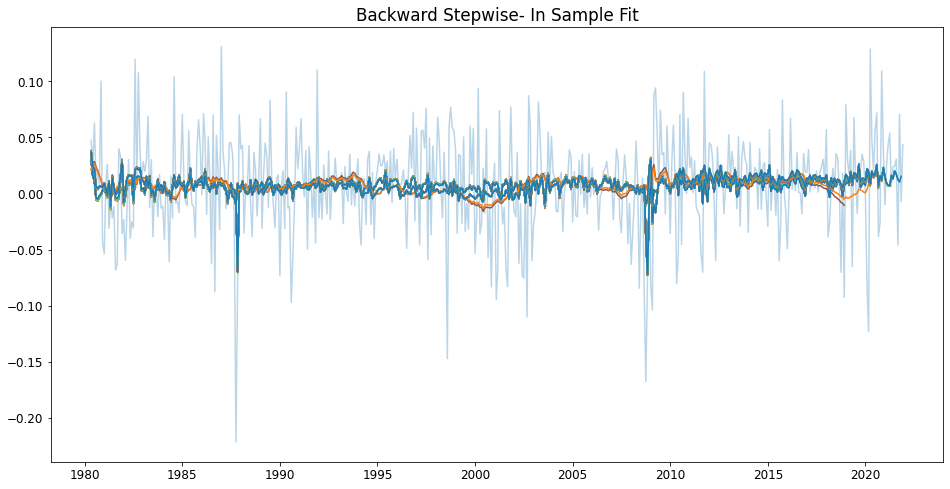

In [ ]:
plt.plot(is_fit['excess_returns'],alpha=0.3)
plt.plot(is_fit.iloc[:,1:])
plt.title('Backward Stepwise- In Sample Fit')

Text(0.5, 1.0, 'Forward Stepwise Test data')

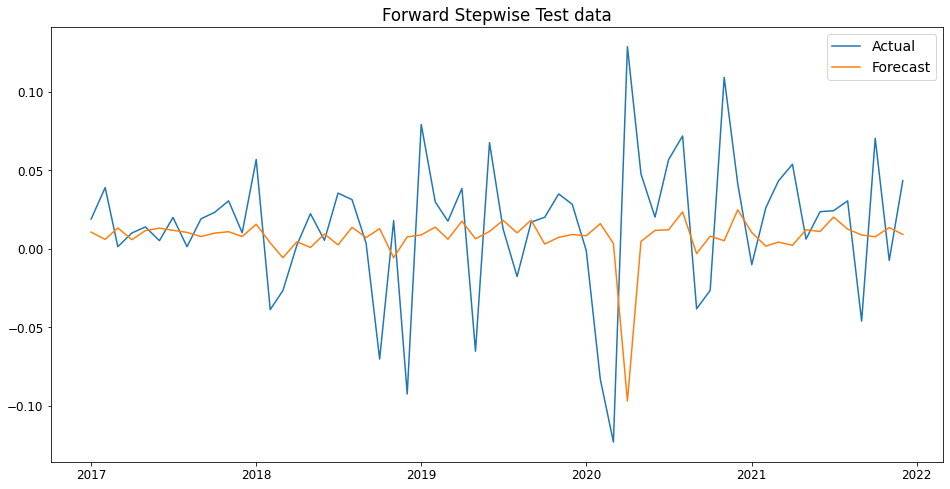

In [ ]:
plt.plot(oos_forecast_fss['actual'])
plt.plot(oos_forecast_fss['forecast'])

# #plt.xlabel('date')
# plt.plot(test_date,res.predict(test_X))
plt.legend(('Actual','Forecast'))
plt.title('Forward Stepwise Test data')
# plt.savefig('Lasso Forecast.png')

## Random Forest

In [ ]:
def timeseries_prediction_trees(input_data, to_predict, cc, param_grid, cv_model, cv_split, val_size, n_jobs=-1, return_params = True):
    """
    parameters:
    -----------
    input_data = data_frame of all input variables(X) to build the model
    to_predict = pandas series of output variables to build the model 
    cv_model = number of cross validation splits
    val_size = number of validation samples to predict on after each cross validation step
    start = initial number of input variables to consider
    alpha = regularizer value for model
    max_iter = maximum iterations to run while running the model
    param_grid = parameter grids to search through
    
    returns:
    --------
    rmse_train = Return the train rmse of all the models
    rmse_test = Return the validation rmse of all the models
    r_squared = Return the r squared value of train set of all the models
    predicted_values = The predicted values over time by each model
    """
       
    scalerst =MinMaxScaler(feature_range=(-1,1))   
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    
    
    cv = TimeSeriesSplit(n_splits = cv_split, test_size= val_size)
    predicted_values = []
    is_fit=[]
    rmse_cv = []
    rmse_train = []
    rmse_test = []
    r_squared = []
    params = []
    x_tr_list=[]
    f_imp=[]
    perm_imp=[]
    shap_imp=[]
    
    for i in range(start,len(input_data)):
        x_new_tr=scalerst.fit_transform(x_new)
        if cv_model =='Random Forest':
            model = RandomizedSearchCV(RandomForestRegressor(bootstrap=False), param_distributions=param_grid, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs=n_jobs)
            results = model.fit(x_new_tr,y_new)
        elif cv_model =='XGBoost':
            model = RandomizedSearchCV(XGBRegressor(), param_distributions=param_grid, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs=n_jobs)
            results = model.fit(x_new_tr,y_new)
        else:
            raise Exception("Please input the cross validation model as Random Forest or XGBoost.")
        
        rmse_cv.append(results.best_score_)
        params.append(results.best_params_)
        
        prediction_train = results.predict(x_new_tr)
        is_fit.append(prediction_train)        
        start = i
        prediction_test = results.predict(scalerst.transform(pd.DataFrame(input_data.loc[i]).T))
        f_imp.append(results.best_estimator_.feature_importances_)
    
        r_squared.append(r2_score(y_new, prediction_train))
#        print(start)
        rmse_train.append(np.sqrt(mean_squared_error(y_new, prediction_train)))
        #rmse_test.append(np.sqrt(mean_squared_error(to_predict[start], prediction_test)))
        
        y_test= pd.Series(to_predict[start])
        # pi=permutation_importance(model,x_new_tr, y_new, scoring = 'neg_mean_squared_error')
        # perm_imp.append(pi.importances_mean.argsort())
        # exp=shap.TreeExplainer(results.best_estimator_)
        # shap_imp.append(exp.shap_values(scalerst.transform(pd.DataFrame(input_data.loc[i]).T)))
        predicted_values = predicted_values + list(prediction_test)
        x_new = x_new.append(pd.DataFrame(input_data.loc[start]).T)
        y_new = y_new.append(pd.Series(to_predict[start]))
        x_tr_list.append(x_new_tr)
    
#    r_squared_out_sample.append(r2_score(to_predict[input_data[input_data[split_column]<=cc].loc[:,columns].shape[0]:], predicted_values))
    rmse_test.append(mean_squared_error(to_predict[cc:], predicted_values))
    
    if return_params:
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, params, f_imp,is_fit

    else:    
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, f_imp,is_fit

In [ ]:
rf_rmse_train,rf_rmse_test, rf_r_squared, rf_predicted_values, rf_rmse_cv, rf_params, rf_imp,fit_is = timeseries_prediction_trees(X,Y,440,
                                                                                                                           {"n_estimators": [30,50,100],"max_features": ['sqrt',3],"max_depth": [6,5],"min_samples_split":[3,5]},
                                                                                                                           'Random Forest', 5, 1, n_jobs=-1, return_params = True)

In [ ]:
oos_forecast_rf=pd.concat([test_Y.reset_index(drop=True),pd.DataFrame(rf_predicted_values)],axis=1)
oos_forecast_rf.columns=['actual','forecast']
oos_forecast_rf.index=test_date

is_fit=pd.concat([Y,pd.DataFrame(fit_is).T],axis=1)
is_fit.index=date

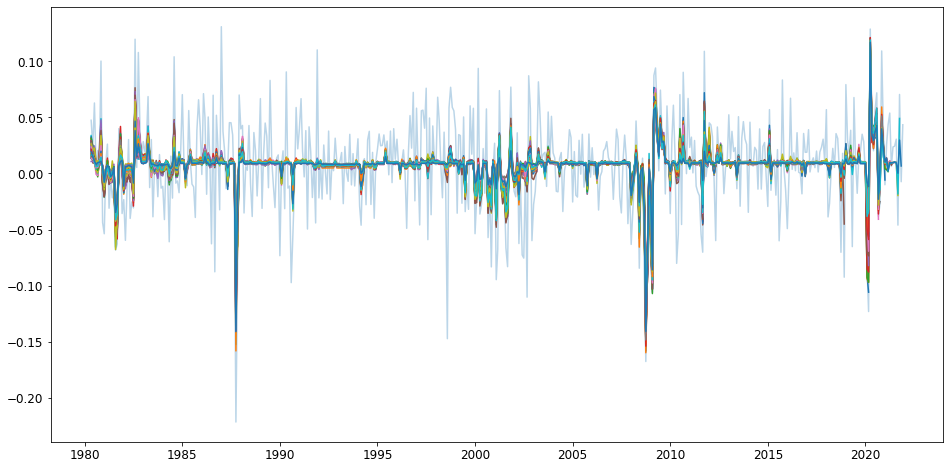

In [ ]:
plt.plot(is_fit['excess_returns'],alpha=0.3)
plt.plot(is_fit.iloc[:,1:])

Text(0.5, 1.0, 'Random Forest Test data')

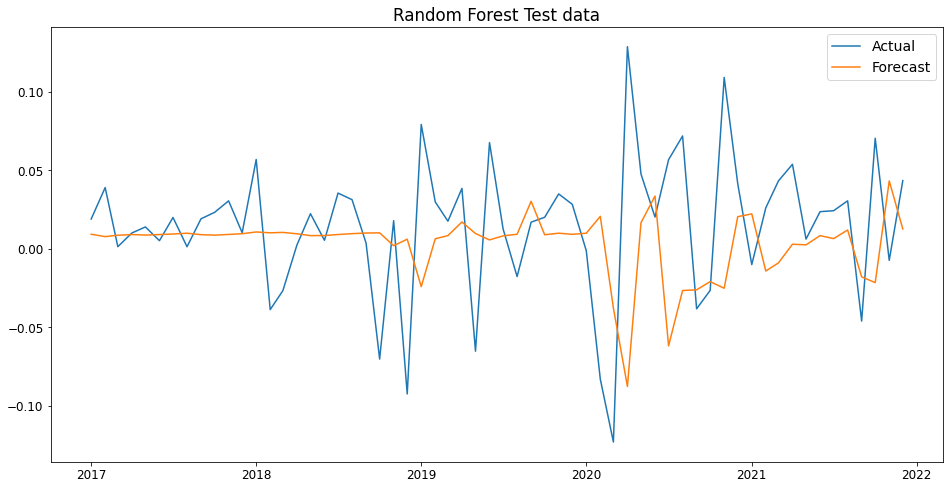

In [ ]:
plt.plot(oos_forecast_rf['actual'])
plt.plot(oos_forecast_rf['forecast'])

# #plt.xlabel('date')
# plt.plot(test_date,res.predict(test_X))
plt.legend(('Actual','Forecast'))
plt.title('Random Forest Test data')
# plt.savefig('Lasso Forecast.png')

## XGBoost

In [ ]:
xgb_rmse_train,xgb_rmse_test, xgb_r_squared, xgb_predicted_values, xgb_rmse_cv, xgb_params, xgb_imp,fit_is = timeseries_prediction_trees(X,Y,440,
                                                                                                                           {"n_estimators": [30,50,100],"max_features": ['sqrt',3],"max_depth": [6,5],"min_samples_split":[3,5]},
                                                                                                                           'XGBoost', 5, 1, n_jobs=-1, return_params = True)

[15:15:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
oos_forecast_xgb=pd.concat([test_Y.reset_index(drop=True),pd.DataFrame(xgb_predicted_values)],axis=1)
oos_forecast_xgb.columns=['actual','forecast']
oos_forecast_xgb.index=test_date

is_fit=pd.concat([Y,pd.DataFrame(fit_is).T],axis=1)
is_fit.index=date

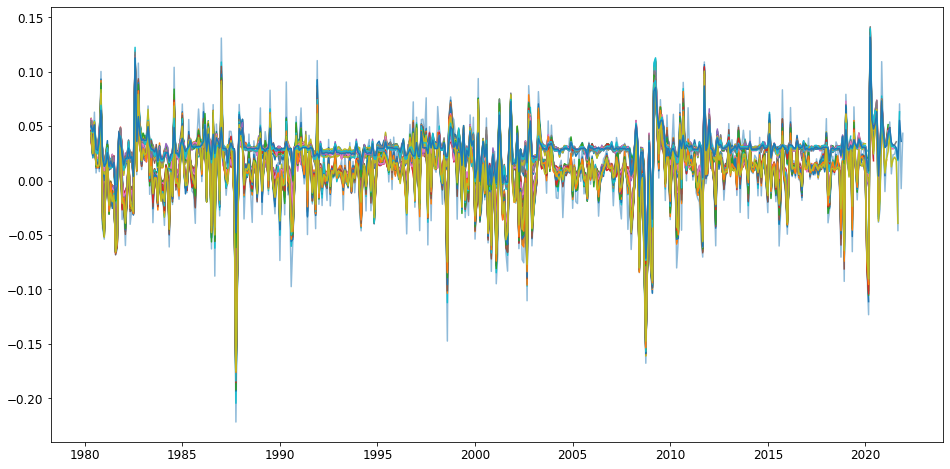

In [ ]:
plt.plot(is_fit['excess_returns'],alpha=0.5)
plt.plot(is_fit.iloc[:,1:])

Text(0.5, 1.0, 'XGBoost Test data')

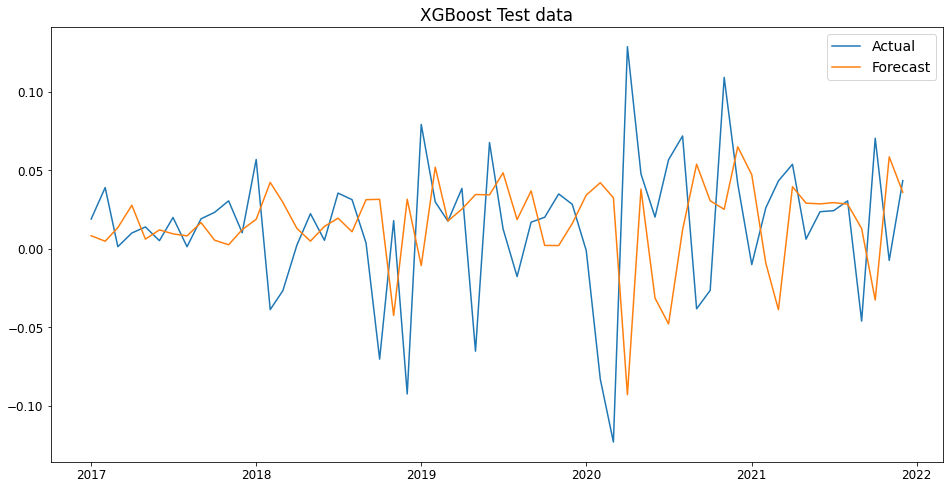

In [ ]:
plt.plot(oos_forecast_xgb['actual'])
plt.plot(oos_forecast_xgb['forecast'])

# #plt.xlabel('date')
# plt.plot(test_date,res.predict(test_X))
plt.legend(('Actual','Forecast'))
plt.title('XGBoost Test data')
# plt.savefig('Lasso Forecast.png')

## Neural Nets

Import necessary libraries

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Normalization
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from numpy.random import seed
seed(123)
tf.random.set_seed(123)
np.random.seed(123)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

Neural Net General Inputs

In [9]:
# Set the Patience Level of Early Stopping
# Iterations increase with patience

#patience =2
#patience =3
#patience =4
#patience =5
patience =6
#patience =7
#patience =8

early_stop = EarlyStopping(monitor='val_loss',patience=patience)

In [10]:
### Select Activation Function by Uncommenting ###

#act_fn = 'elu'       # Exponential Linear Unit
#act_fn = 'gelu'      # Gaussian error linear unit
#act_fn = 'selu'      # Scaled Exponential Linear Unit 
act_fn = 'relu'      # Rectified Linear Unit
#act_fn = 'sigmoid'   # Sigmoid activation

In [11]:
### Select Loss Function by Uncommenting ###

#loss = 'mean_squared_error' # Mean Squared Error Loss
loss = 'huber' #Huber Loss
#loss = 'mean_absolute_error 


In [12]:

### Select Optimizer by Uncommenting ###

#optimizer = 'Adadelta' # Adadelta
optimizer = 'adam' # Adam
#optimizer = 'SGD'  # Stochastic Gradient Descent

### Shallow Neural Net (1 Layer)

Shallow Neural Net Specific Inputs

In [13]:
### Select Number of Neurons by Uncommenting ###

#neurons = 3
#neurons = 6
#neurons = 9
neurons = 12


In [14]:
def timeseries_prediction_NN1(input_data, to_predict, cc, epochs=500, early_stop_ = False):
    """
    parameters:
    -----------
    input_data = data_frame of all input variables(X) to build the model
    to_predict = pandas series of output variables to build the model 
    cv = number of cross validation splits
    val_size = number of validation samples to predict on after each cross validation step
    start = initial number of input variables to consider
    alpha = regularizer value for model
    max_iter = maximum iterations to run while running the model
    
    returns:
    --------
    rmse_train = Return the train rmse of all the models
    rmse_test = Return the validation rmse of all the models
    r_squared = Return the r squared value of train set of all the models
    predicted_values = The predicted values over time by each model
    """
#    scalerst =MinMaxScaler(feature_range=(-1,1))       
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    
    predicted_values = []
    predicted_is=[]
    rmse_train = []
    rmse_test = []
    r_squared = []
    best_param=[]
    perm_imp=[]
    shap_imp = []
    
    for i in range(start+12,len(input_data),12):
        x_val = x_new.loc[start-12:,]
        y_val = y_new[x_new.shape[0]-12:]

        if early_stop_:

                normalizer=Normalization(axis=-1)
                model=Sequential(normalizer)
                model.add(Dense(neurons,activation=act_fn))
                model.add(Dense(1))
                model.compile(loss=loss,optimizer=optimizer)
                model.fit(x_new,y_new,validation_data=(x_val,y_val),epochs=epochs,callbacks=[early_stop])
        else:

                normalizer=Normalization(axis=-1)
                model=Sequential(normalizer)
                model.add(Dense(neurons,activation=act_fn))
                model.add(Dense(1))
                model.compile(loss=loss,optimizer=optimizer)
                model.fit(x_new,y_new,validation_data=(x_val,y_val),epochs=epochs)

        # best_alpha_index = np.where(results.alphas_==results.alpha_)[0][0]
        # rmse_cv.append(results.mse_path_[best_alpha_index])
        # alphas.append(model.alpha_)
        
        prediction_train = model.predict(x_new)
        #test_data= pd.DataFrame(MinMaxScaler(feature_range=(-1,1)).fit_transform(input_data.loc[:start,:]))
        prediction_test = model.predict((pd.DataFrame(input_data.loc[i-12:i-1])))
#        print(len(prediction_test))
#        print(prediction_test)
        r_squared.append(r2_score(y_new, prediction_train))
        rmse_train.append(mean_squared_error(y_new, prediction_train))
        predicted_is.append(prediction_train)
        #rmse_test.append(np.sqrt(mean_squared_error(to_predict[start], prediction_test)))
        
        start = i
#         pi=permutation_importance(model,x_new_tr, y_new, scoring = 'neg_mean_squared_error')
#         exp=shap.KernelExplainer(model, x_new_tr)
#         shap_imp.append(exp.shap_values(scalerst.transform(pd.DataFrame(input_data.loc[i]).T)))
        predicted_values =  predicted_values + [i[0] for i in prediction_test]
#        print(predicted_values)
#        y_test= pd.Series(to_predict[start])
#         perm_imp.append(pi.importances_mean.argsort())
        x_new = input_data.loc[:start-1,]        
        y_new = to_predict[:start]
#        x_tr_list.append(x_new_tr)
    
    rmse_test.append(mean_squared_error(to_predict[cc+1:], predicted_values))
    
    return rmse_train, rmse_test, r_squared, predicted_values,predicted_is


In [15]:
rmse_train, rmse_test, r_squared, predicted_values,predicted_is = timeseries_prediction_NN1(X, Y, 439, epochs=500, early_stop_ = True)

Epoch 1/500
14/14 [==============================] - 1s 19ms/step - loss: 10.0646 - val_loss: 16.9025
Epoch 2/500
14/14 [==============================] - 0s 4ms/step - loss: 6.1073 - val_loss: 8.3418
Epoch 3/500
14/14 [==============================] - 0s 6ms/step - loss: 2.2337 - val_loss: 0.0633
Epoch 4/500
14/14 [==============================] - 0s 6ms/step - loss: 0.3410 - val_loss: 1.8087
Epoch 5/500
14/14 [==============================] - 0s 5ms/step - loss: 0.1820 - val_loss: 0.0385
Epoch 6/500
14/14 [==============================] - 0s 5ms/step - loss: 0.1275 - val_loss: 0.7419
Epoch 7/500
14/14 [==============================] - 0s 4ms/step - loss: 0.0948 - val_loss: 0.1985
Epoch 8/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0755 - val_loss: 0.3681
Epoch 9/500
14/14 [==============================] - 0s 4ms/step - loss: 0.0634 - val_loss: 0.1295
Epoch 10/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0497 - val_loss: 0.2529
Epoch 

In [16]:
is_list=[]
for i in range(0,5):
  is_list.append(pd.DataFrame(predicted_is[i]))

  

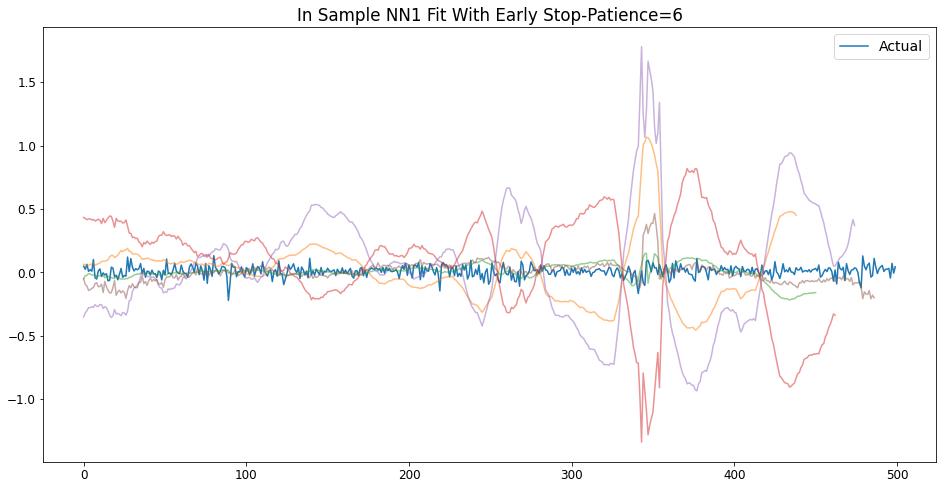

In [17]:
df_is=pd.concat(is_list,axis=1)
df_is=pd.concat([pd.Series(Y),df_is],axis=1)
df_is.columns=['Actual','Fit_1','Fit_2','Fit_3','Fit_4','Fit_5']

plt.plot(df_is['Actual'],label='Actual')
plt.plot(df_is.iloc[:,1:],alpha=0.5)
plt.title('In Sample NN1 Fit With Early Stop-Patience=6')
plt.legend()
plt.show()


Text(0.5, 1.0, 'NN1 Out of Sample Forecast with Early Stop-Patience=6')

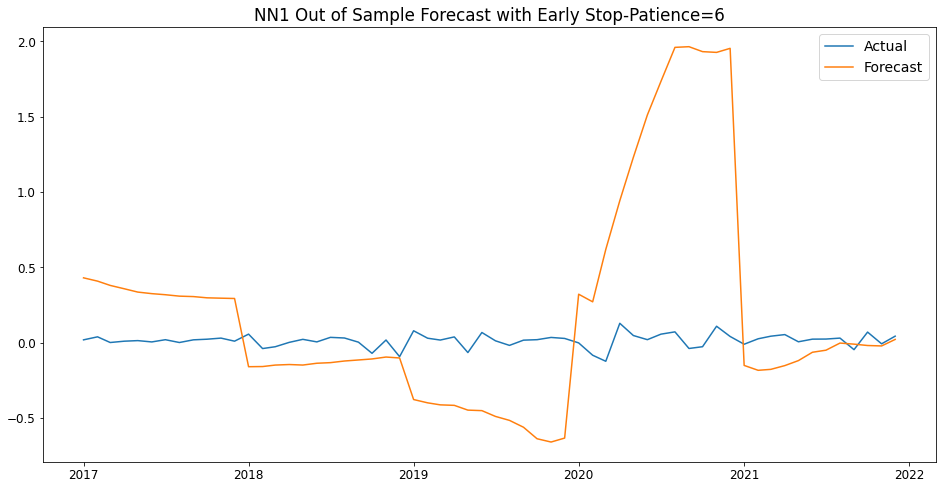

In [18]:
nn1_oos=pd.concat([test_Y.reset_index(drop=True),pd.Series(predicted_values)],axis=1)
nn1_oos.columns=['Actual','Forecast']
nn1_oos.set_index(test_date,inplace=True)
plt.plot(nn1_oos)
plt.legend(('Actual','Forecast'))
plt.title('NN1 Out of Sample Forecast with Early Stop-Patience=6')

In [19]:
rmse_train, rmse_test, r_squared, predicted_values,predicted_is = timeseries_prediction_NN1(X, Y, 439, epochs=100, early_stop_ = False)

Epoch 1/100
14/14 [==============================] - 1s 16ms/step - loss: 2.2709 - val_loss: 3.1847
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 0.4020 - val_loss: 0.5625
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2627 - val_loss: 2.5827
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2106 - val_loss: 1.4274
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1875 - val_loss: 1.8321
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1676 - val_loss: 1.6949
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1572 - val_loss: 1.4280
Epoch 8/100
14/14 [==============================] - 0s 4ms/step - loss: 0.1490 - val_loss: 1.6397
Epoch 9/100
14/14 [==============================] - 0s 5ms/step - loss: 0.1465 - val_loss: 0.9781
Epoch 10/100
14/14 [==============================] - 0s 5ms/step - loss: 0.1323 - val_loss: 1.4352
Epoch 11

In [20]:
is_list=[]
for i in range(0,5):
  is_list.append(pd.DataFrame(predicted_is[i]))

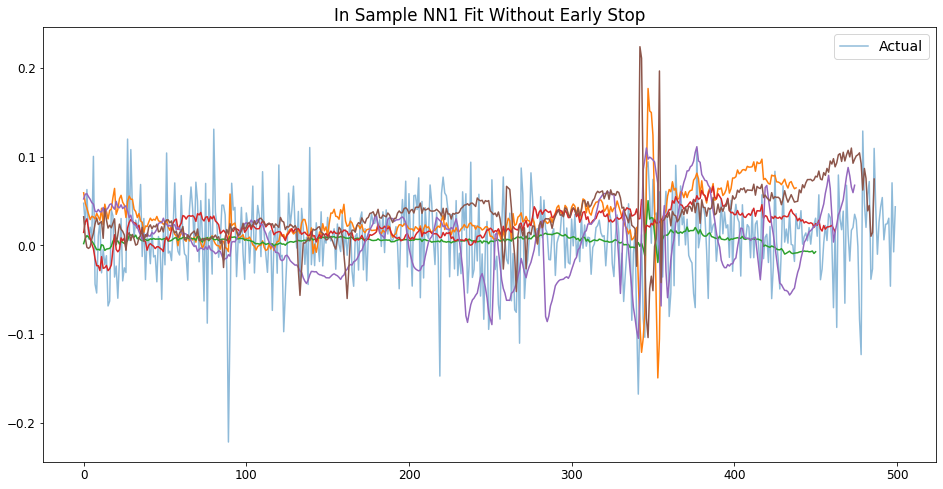

In [21]:
df_is=pd.concat(is_list,axis=1)
df_is=pd.concat([pd.Series(Y),df_is],axis=1)
df_is.columns=['Actual','Fit_1','Fit_2','Fit_3','Fit_4','Fit_5']

plt.plot(df_is['Actual'],label='Actual',alpha=0.5)
plt.plot(df_is.iloc[:,1:])
plt.title('In Sample NN1 Fit Without Early Stop')
plt.legend()
plt.show()

Text(0.5, 1.0, 'NN1 Out of Sample Forecast without Early Stop')

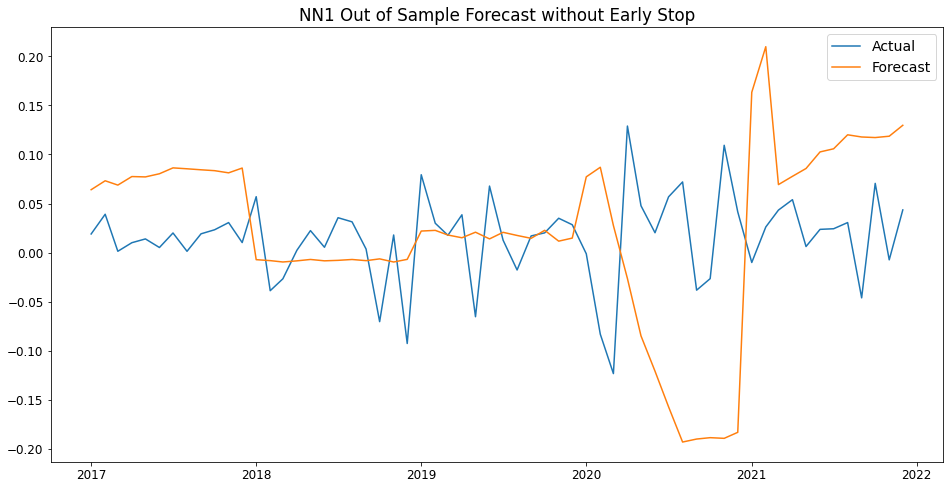

In [22]:
nn1_oos=pd.concat([test_Y.reset_index(drop=True),pd.Series(predicted_values)],axis=1)
nn1_oos.columns=['Actual','Forecast']
nn1_oos.set_index(test_date,inplace=True)
plt.plot(nn1_oos)
plt.legend(('Actual','Forecast'))
plt.title('NN1 Out of Sample Forecast without Early Stop')

### Deep Neural Net (3 Layers)

Deep Neural Net Specific Inputs

In [23]:
### Select Number of Neurons by Uncommenting ###

## Select Number of Neurons for Layer 1 

#neurons_1 = 4
#neurons_1 = 16
neurons_1 = 100

## Select Number of Neurons for Layer 2 

#neurons_2 = 8
neurons_2 = 50
#neurons_2 = 100

## Select Number of Neurons for Layer 3 

neurons_3 = 32
#neurons_3 = 50
#neurons_3 = 100

## If Same Neuron for all Layers, Select Below:

#neurons_glb = 12
#neurons_glb = 30
#neurons_glb = 50
#neurons_glb = 100





In [24]:
def timeseries_prediction_NN3(input_data, to_predict, cc, epochs=500, early_stop_ = False):
    """
    parameters:
    -----------
    input_data = data_frame of all input variables(X) to build the model
    to_predict = pandas series of output variables to build the model 
    cv = number of cross validation splits
    val_size = number of validation samples to predict on after each cross validation step
    start = initial number of input variables to consider
    alpha = regularizer value for model
    max_iter = maximum iterations to run while running the model
    
    returns:
    --------
    rmse_train = Return the train rmse of all the models
    rmse_test = Return the validation rmse of all the models
    r_squared = Return the r squared value of train set of all the models
    predicted_values = The predicted values over time by each model
    """
#    scalerst =MinMaxScaler(feature_range=(-1,1))       
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    
    predicted_values = []
    predicted_is=[]
    rmse_train = []
    rmse_test = []
    r_squared = []
    best_param=[]
    perm_imp=[]
    shap_imp = []
    
    for i in range(start+12,len(input_data),12):
        x_val = x_new.loc[start-12:,]
        y_val = y_new[x_new.shape[0]-12:]

        if early_stop_:

                normalizer=Normalization(axis=-1)
                model=Sequential(normalizer)
                model.add(Dense(neurons_1,activation=act_fn))
                model.add(Dense(neurons_2,activation=act_fn))
                model.add(Dense(neurons_3,activation=act_fn))
                model.add(Dense(1))
                model.compile(loss=loss,optimizer=optimizer)
                model.fit(x_new,y_new,validation_data=(x_val,y_val),epochs=epochs,callbacks=[early_stop])
        else:

                normalizer=Normalization(axis=-1)
                model=Sequential(normalizer)
                model.add(Dense(neurons_1,activation=act_fn))
                model.add(Dense(neurons_2,activation=act_fn))
                model.add(Dense(neurons_3,activation=act_fn))
                model.add(Dense(1))
                model.compile(loss=loss,optimizer=optimizer)
                model.fit(x_new,y_new,validation_data=(x_val,y_val),epochs=epochs)

        # best_alpha_index = np.where(results.alphas_==results.alpha_)[0][0]
        # rmse_cv.append(results.mse_path_[best_alpha_index])
        # alphas.append(model.alpha_)
        
        prediction_train = model.predict(x_new)
        #test_data= pd.DataFrame(MinMaxScaler(feature_range=(-1,1)).fit_transform(input_data.loc[:start,:]))
        prediction_test = model.predict((pd.DataFrame(input_data.loc[i-12:i-1])))
#        print(len(prediction_test))
#        print(prediction_test)
        r_squared.append(r2_score(y_new, prediction_train))
        rmse_train.append(mean_squared_error(y_new, prediction_train))
        predicted_is.append(prediction_train)
        #rmse_test.append(np.sqrt(mean_squared_error(to_predict[start], prediction_test)))
        
        start = i
#         pi=permutation_importance(model,x_new_tr, y_new, scoring = 'neg_mean_squared_error')
#         exp=shap.KernelExplainer(model, x_new_tr)
#         shap_imp.append(exp.shap_values(scalerst.transform(pd.DataFrame(input_data.loc[i]).T)))
        predicted_values =  predicted_values + [i[0] for i in prediction_test]
#        print(predicted_values)
#        y_test= pd.Series(to_predict[start])
#         perm_imp.append(pi.importances_mean.argsort())
        x_new = input_data.loc[:start-1,]        
        y_new = to_predict[:start]
#        x_tr_list.append(x_new_tr)
    
    rmse_test.append(mean_squared_error(to_predict[cc+1:], predicted_values))
    
    return rmse_train, rmse_test, r_squared, predicted_values,predicted_is


In [25]:
rmse_train, rmse_test, r_squared, predicted_values,predicted_is = timeseries_prediction_NN3(X, Y, 439, epochs=500, early_stop_ = True)

Epoch 1/500
14/14 [==============================] - 1s 19ms/step - loss: 0.4054 - val_loss: 0.0753
Epoch 2/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0400 - val_loss: 0.0040
Epoch 3/500
14/14 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0010
Epoch 4/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0092
Epoch 5/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0107
Epoch 6/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 3.8658e-04
Epoch 7/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 9.9743e-04
Epoch 8/500
14/14 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 4.5892e-04
Epoch 9/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 4.0964e-04
Epoch 10/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss:

In [26]:
is_list=[]
for i in range(0,5):
  is_list.append(pd.DataFrame(predicted_is[i]))

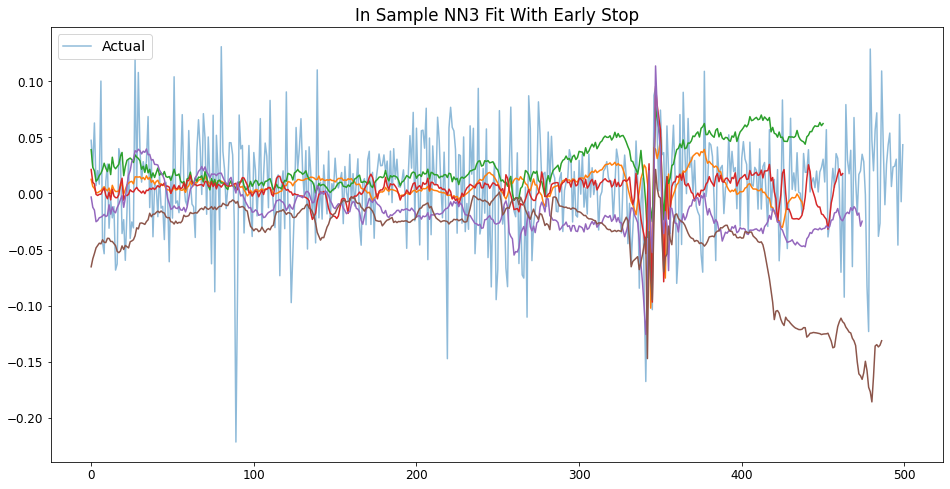

In [27]:
df_is=pd.concat(is_list,axis=1)
df_is=pd.concat([pd.Series(Y),df_is],axis=1)
df_is.columns=['Actual','Fit_1','Fit_2','Fit_3','Fit_4','Fit_5']

plt.plot(df_is['Actual'],label='Actual',alpha=0.5)
plt.plot(df_is.iloc[:,1:])
plt.title('In Sample NN3 Fit With Early Stop')
plt.legend()
plt.show()

Text(0.5, 1.0, 'NN3 Out of Sample Forecast with Early Stop')

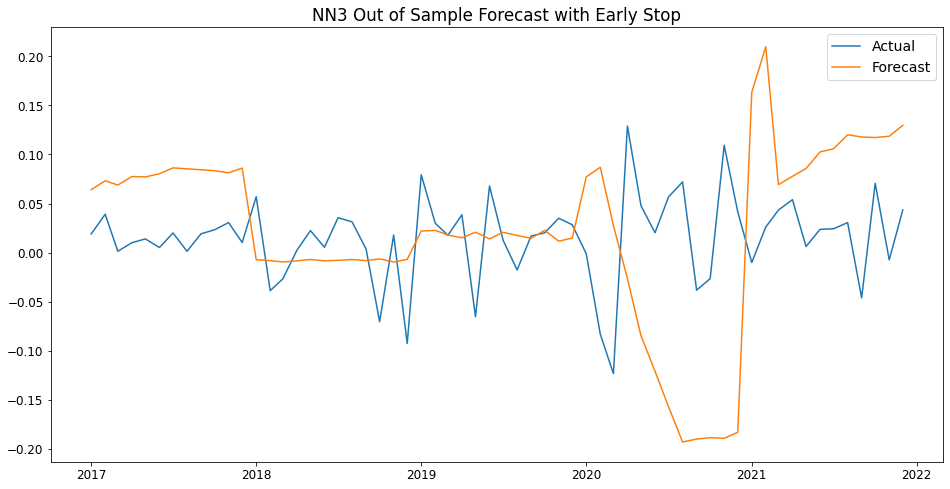

In [28]:
nn3_oos=pd.concat([test_Y.reset_index(drop=True),pd.Series(predicted_values)],axis=1)
nn3_oos.columns=['Actual','Forecast']
nn3_oos.set_index(test_date,inplace=True)
plt.plot(nn1_oos)
plt.legend(('Actual','Forecast'))
plt.title('NN3 Out of Sample Forecast with Early Stop')

In [29]:
rmse_train, rmse_test, r_squared, predicted_values,predicted_is = timeseries_prediction_NN3(X, Y, 439, epochs=500, early_stop_ = False)

Streaming output truncated to the last 5000 lines.
14/14 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/500
14/14 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 4.1420e-04
Epoch 9/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 10/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 7.7697e-04
Epoch 11/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 6.3867e-04
Epoch 12/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 7.7356e-04
Epoch 13/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 4.8126e-04
Epoch 14/500
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 15/500
14/14 [=========================

In [30]:
is_list=[]
for i in range(0,5):
  is_list.append(pd.DataFrame(predicted_is[i]))

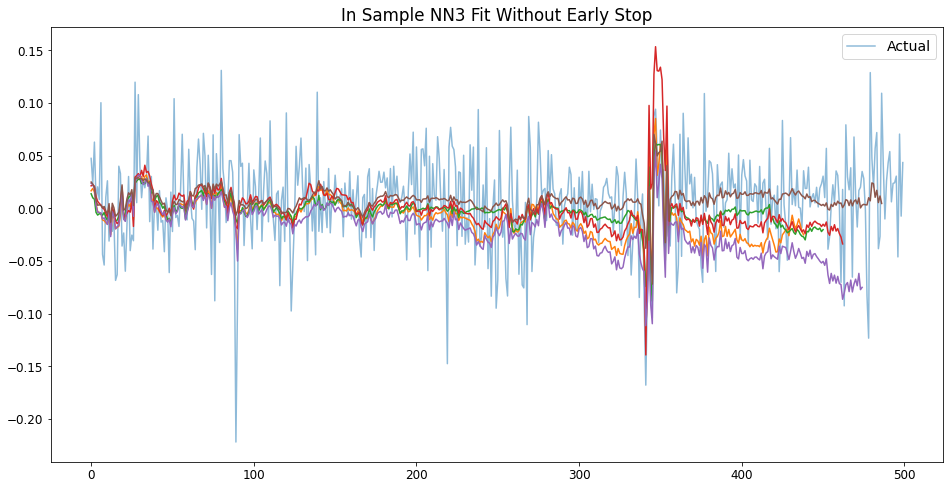

In [31]:
df_is=pd.concat(is_list,axis=1)
df_is=pd.concat([pd.Series(Y),df_is],axis=1)
df_is.columns=['Actual','Fit_1','Fit_2','Fit_3','Fit_4','Fit_5']

plt.plot(df_is['Actual'],label='Actual',alpha=0.5)
plt.plot(df_is.iloc[:,1:])
plt.title('In Sample NN3 Fit Without Early Stop')
plt.legend()
plt.show()

Text(0.5, 1.0, 'NN3 Out of Sample Forecast without Early Stop')

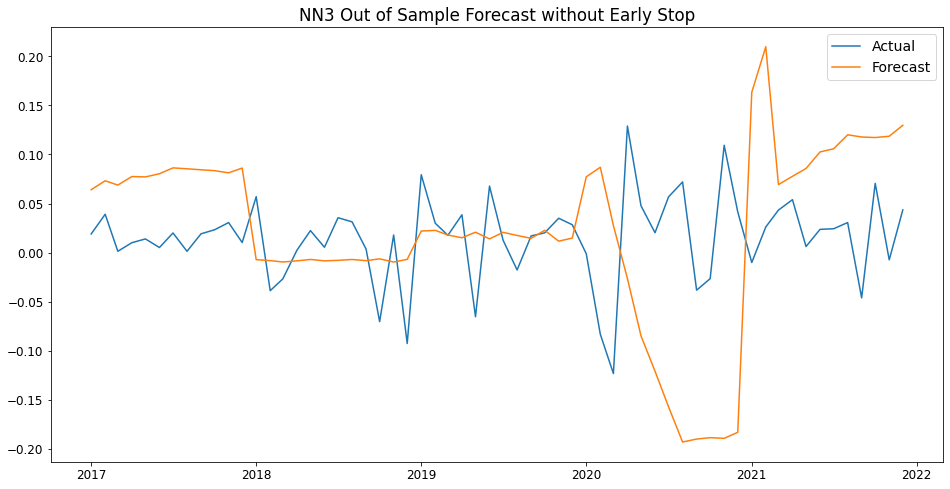

In [32]:
nn3_oos=pd.concat([test_Y.reset_index(drop=True),pd.Series(predicted_values)],axis=1)
nn3_oos.columns=['Actual','Forecast']
nn3_oos.set_index(test_date,inplace=True)
plt.plot(nn1_oos)
plt.legend(('Actual','Forecast'))
plt.title('NN3 Out of Sample Forecast without Early Stop')

## Lasso Regression

In [33]:
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score,mean_squared_error

In [34]:
def timeseries_prediction_lasso(input_data, to_predict, cv_model, cv_split, val_size, cc, n_jobs, max_iter=1000000, return_alphas = False):
    """
    parameters:
    -----------
    input_data = data_frame of all input variables(X) to build the model
    to_predict = pandas series of output variables to build the model 
    cv = number of cross validation splits
    val_size = number of validation samples to predict on after each cross validation step
    start = initial number of input variables to consider
    alpha = regularizer value for model
    max_iter = maximum iterations to run while running the model
    
    returns:
    --------
    rmse_train = Return the train rmse of all the models
    rmse_test = Return the validation rmse of all the models
    r_squared = Return the r squared value of train set of all the models
    predicted_values = The predicted values over time by each model
    """
    scalerst =MinMaxScaler(feature_range=(-1,1))       
    start = cc
    x_new = input_data.loc[:start-1,]
    y_new = to_predict[:start]
    alpha_=np.linspace(0.0001,2,1000)
    
    
    cv = TimeSeriesSplit(n_splits = cv_split, test_size= val_size)
    predicted_values = []
    
    rmse_cv = []
    rmse_train = []
    rmse_test = []
    r_squared = []
    alphas = []
    coef=[]
    is_fit=[]
    
    for i in range(start,len(input_data)):
        x_new_tr=pd.DataFrame(scalerst.fit_transform(x_new))
        if cv_model =='Lasso':
            model = LassoCV(alphas=alpha_,n_alphas=1000,cv=cv,n_jobs=n_jobs,max_iter=max_iter)
            results = model.fit(x_new_tr,y_new)
        elif cv_model =='Enet':
            model = ElasticNetCV(alphas=alpha_,n_alphas=1000,cv=cv,n_jobs=n_jobs,max_iter=max_iter)
            results = model.fit(x_new_tr,y_new)
        else:
            raise Exception("Please input the cross validation model as Lasso, or Enet.")
        
        best_alpha_index = np.where(results.alphas_==results.alpha_)[0][0]
        rmse_cv.append(results.mse_path_[best_alpha_index])
        alphas.append(model.alpha_)
        
        coef.append(results.coef_)
        prediction_train = results.predict(x_new_tr)
        is_fit.append(prediction_train)
        #test_data= pd.DataFrame(MinMaxScaler(feature_range=(-1,1)).fit_transform(input_data.loc[:start,:]))
        prediction_test = results.predict(scalerst.transform(pd.DataFrame(input_data.loc[i]).T))
        
        r_squared.append(r2_score(y_new, prediction_train))
        rmse_train.append(mean_squared_error(y_new, prediction_train))
        #rmse_test.append(np.sqrt(mean_squared_error(to_predict[start], prediction_test)))
        
        start = i
        x_new = x_new.append(pd.DataFrame(input_data.loc[start]).T)
        y_new = y_new.append(pd.Series(to_predict[start]))
        predicted_values.append(prediction_test[0])
    
    rmse_test.append(mean_squared_error(to_predict[cc:], predicted_values))
    
    if return_alphas:
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, is_fit,alphas

    else:    
        return rmse_train, rmse_test, r_squared, predicted_values, rmse_cv,is_fit,coef

In [35]:
rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, fit_is,alphas = timeseries_prediction_lasso(input_data=X,
                                                                                                         to_predict=Y,
                                                                                                         cv_model='Lasso',
                                                                                                         cv_split=5,
                                                                                                         val_size=1,
                                                                                                         cc=440,n_jobs=-1,return_alphas=True)

In [36]:
oos_forecast_lasso=pd.concat([test_Y.reset_index(drop=True),pd.DataFrame(predicted_values)],axis=1)
oos_forecast_lasso.columns=['actual','forecast']
oos_forecast_lasso.index=test_date

In [37]:
is_fit=pd.concat([Y,pd.DataFrame(fit_is).T],axis=1)
is_fit.index=date

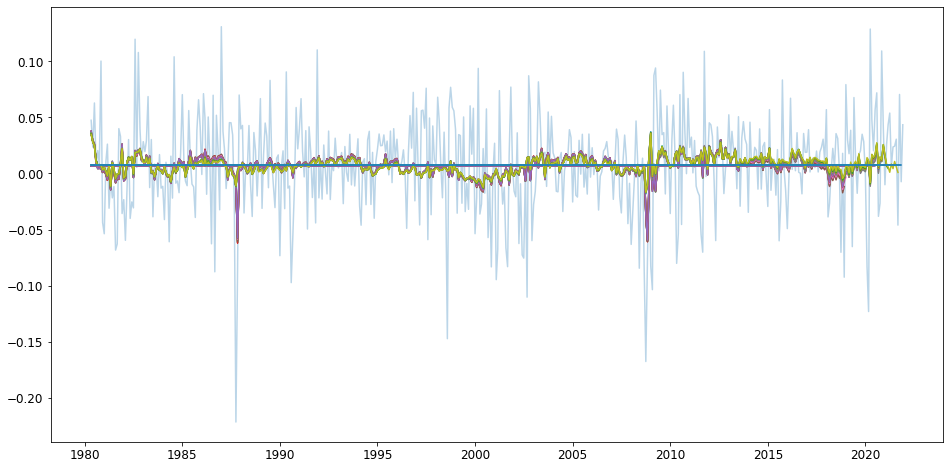

In [38]:
plt.plot(is_fit['excess_returns'],alpha=0.3)
plt.plot(is_fit.iloc[:,1:])


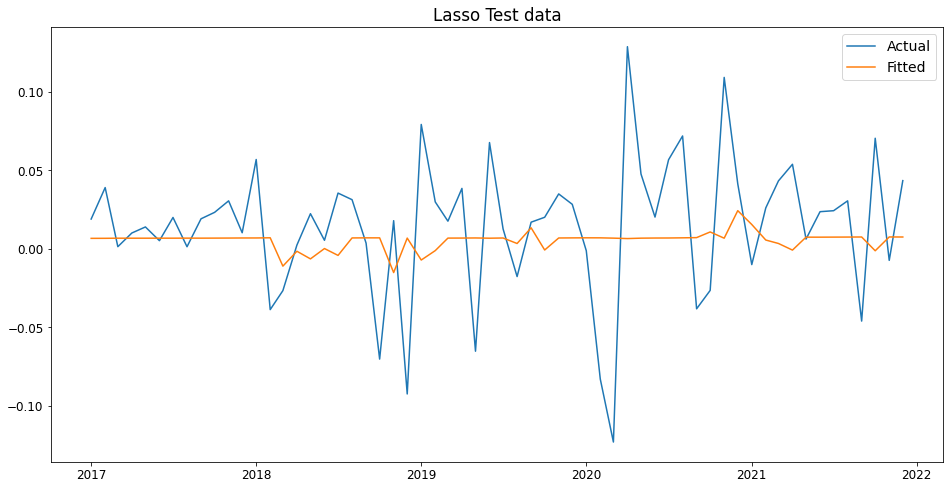

In [39]:
plt.plot(oos_forecast_lasso['actual'])
plt.plot(oos_forecast_lasso['forecast'])

# #plt.xlabel('date')
# plt.plot(test_date,res.predict(test_X))
plt.legend(('Actual','Fitted'))
plt.title('Lasso Test data')
plt.savefig('Lasso Forecast.png')

## ElasticNet

In [40]:
rmse_train, rmse_test, r_squared, predicted_values, rmse_cv, fit_is,alphas = timeseries_prediction_lasso(input_data=X,
                                                                                                         to_predict=Y,
                                                                                                         cv_model='Enet',
                                                                                                         cv_split=5,
                                                                                                         val_size=1,
                                                                                                         cc=440,n_jobs=-1,return_alphas=True)


In [41]:
oos_forecast_enet=pd.concat([test_Y.reset_index(drop=True),pd.DataFrame(predicted_values)],axis=1)
oos_forecast_enet.columns=['actual','forecast']
oos_forecast_enet.index=test_date

In [42]:
is_fit=pd.concat([Y,pd.DataFrame(fit_is).T],axis=1)
is_fit.index=date

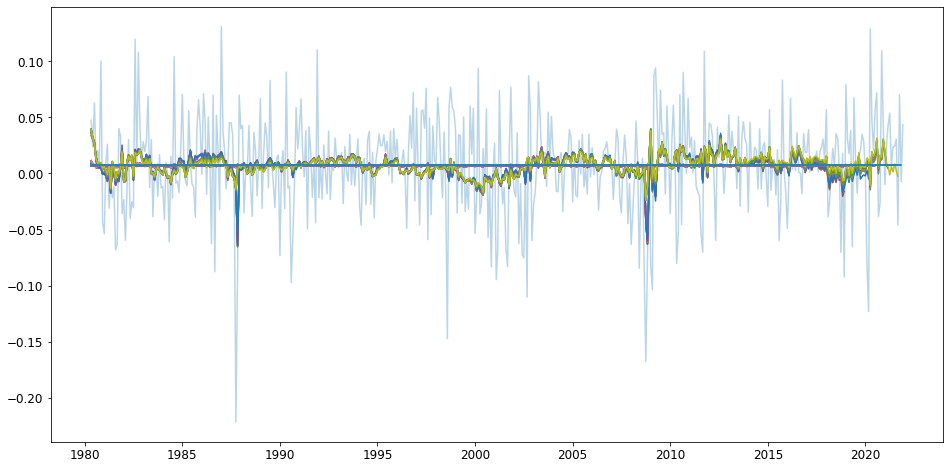

In [43]:
plt.plot(is_fit['excess_returns'],alpha=0.3)
plt.plot(is_fit.iloc[:,1:])

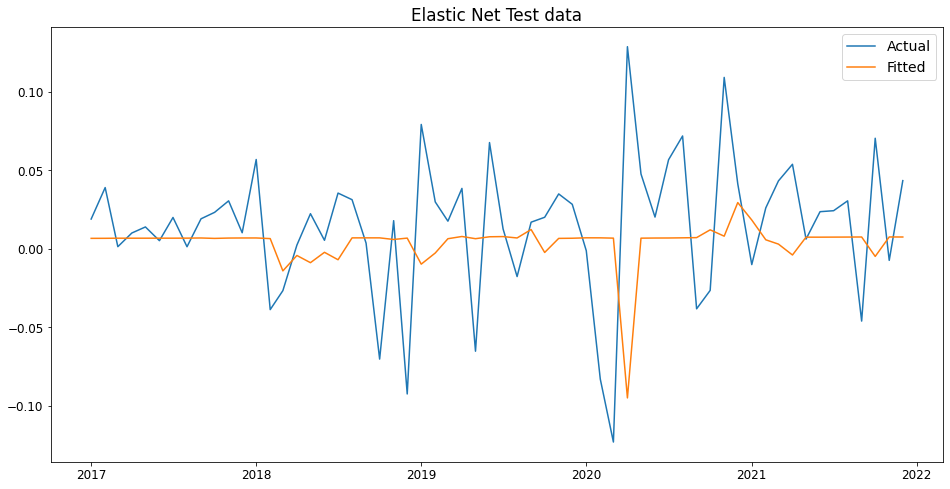

In [44]:
plt.plot(oos_forecast_enet['actual'])
plt.plot(oos_forecast_enet['forecast'])

# #plt.xlabel('date')
# plt.plot(test_date,res.predict(test_X))
plt.legend(('Actual','Fitted'))
plt.title('Elastic Net Test data')
plt.savefig('Elastic Net Forecast.png')

In [45]:
#df['column'] = df.groupby(['category'])['column'].apply(lambda x:x.fillna(x.median()))